In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; N = 0
for u in S:
    id_[u] = N; _id[N] = u
    N += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out and (origin != 13207 or dest != 13934):
        G.add_edge(id_[origin], id_[dest])
G.add_edge(id_[13207], id_[14104])

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [3]:
get_size_weight(G, W, [0] * N, 744)

(4586, 110204.42095686687)

In [4]:
ids = [13934, 14104, 13949, 15720, 13932, 13923, 14930, 131454, 15996, 15671, 13896, 15487]
tested_ids = [id_[u] for u in ids]
tested_ids

[2149, 2319, 2164, 3929, 2150, 2140, 3141, 274, 4201, 3876, 2113, 3692]

In [5]:
tested_ids = set(tested_ids)
sample = []

V = [0] * N

Q = deque([744])
while Q and tested_ids:
    
    u = Q.popleft()
    
    if u in tested_ids:
        sample.append(u)
        
    for v in G.predecessors(u):
        if not V[v]:
            Q.append(v)
            V[v] = 1

print(sample)

[2149, 2319, 2164, 3929, 2150, 2140, 3141, 274, 4201, 3876, 2113, 3692]


In [6]:
def visit_robust(G, V, root, u):
    
    N = len(V)
    I = get_ideal_robust(G, V, root, u)
    
    V_ = V.copy()
    for u in I:
        V_[u] = 1
    
    return V_, len(I)

In [7]:
WI = {}
V = [0] * N; VR = [0] * N
for u in sample[::-1]:
    s, w = get_size_weight(G, W, V, u)
    s, w_low = get_size_weight_robust(G, W, V, 744, u)
    s, w_high = get_size_weight(G, W, VR, u)
    WI[_id[u]] = w
    V, _ = visit(G, V, u)
    VR, _ = visit_robust(G, VR, 744, u)
    print(_id[u], ' ' * 4, round(w, 1), ' ' * 4, round(w_low, 1), ' ' * 4, round(w_high, 1), ' ' * 4, round(get_size_weight(G, W, [0] * N, u)[1], 1), ' ' * 4, round(get_size_weight_robust(G, W, [0] * N, 744, u)[1], 1))

15487      2276.7      548.4      2276.7      2276.7      548.4
13896      98.3      98.3      1826.7      1826.7      98.3
15671      12813.9      12600.4      12813.9      12813.9      12600.4
15996      10364.9      10253.2      10540.8      10540.8      10253.2
131454      14096.2      7419.6      14245.8      39650.2      7419.6
14930      4881.1      4665.7      5393.5      5393.5      4665.7
13923      3680.9      3680.9      3896.4      9074.4      8562.0
13932      8696.6      7428.6      8696.6      8696.6      7428.6
15720      13999.8      12752.6      13999.8      13999.8      12752.6
13949      8502.0      8502.0      9770.0      9770.0      8502.0
14104      23409.4      23409.4      24656.6      37409.3      37409.3
13934      7384.3      7384.3      13586.4      110204.4      110204.4


In [8]:
def plot_sample_no_intersections(G, V_, sample, geom, _id, name):
    
    geometry = geom.copy(); N = len(V_)
    
    V = V_.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            C[u] = i + 1
            
    newC = list(range(len(sample)))
    random.shuffle(newC)
    for u in range(N):
        if C[u] > 0:
            C[u] = newC[C[u] - 1] + 1
            
    newC_ = [0] * len(newC)
    for i in range(len(newC)):
        newC_[newC[i]] = i

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
    coord = points_coordinates(sample, geometry, _id)
    
    for i in range(len(coord)):
        coord[i] = coord[i].buffer(100)
    
    for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i + 1] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [newC[i] + 1]

    label_ids = "   ".join([f"{i + 1}: {_id[sample[newC_[i]]]}" for i in range(len(sample))])
        
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                       figsize=(15, 15),
                       legend = True,
                       legend_kwds={'label': f"-1: No considerado   0: No cubierto   "+ label_ids, 'orientation': "horizontal"},
                       cmap = 'nipy_spectral',)
    plt.savefig(f"{name}.pdf", dpi=1000)

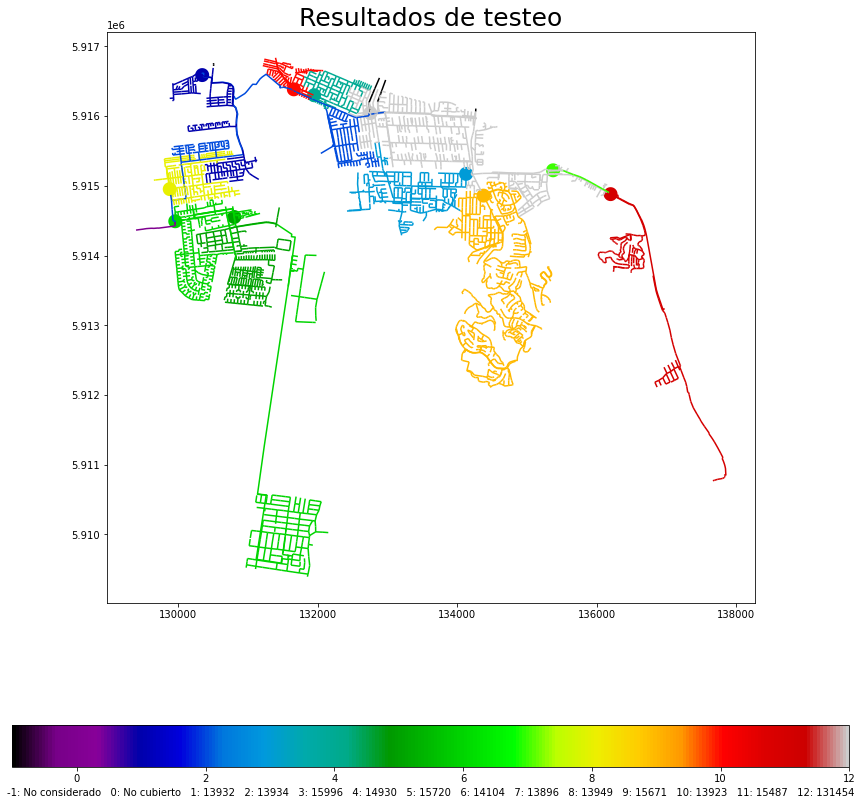

In [9]:
plot_sample_no_intersections(G, [0] * N, sample[::-1] , geometry, _id, "map_orig")

In [10]:
DG = nx.DiGraph()

ss = set(sample)

for r in sample:
    
    V = [0] * N
    
    Q = deque([r])
    while Q:
        
        u = Q.popleft()
        
        for v in G.predecessors(u):
            if not V[v] and v not in ss:
                Q.append(v)
                V[v] = 1
            if not V[v] and v in ss:
                DG.add_edge(_id[r], _id[v])
                V, _ = visit(G, V, v)

In [11]:
print(DG.edges())

[(13934, 14104), (13934, 13949), (13934, 13932), (13934, 13923), (13934, 131454), (14104, 15720), (13923, 14930), (131454, 15996), (131454, 15671), (131454, 13896), (131454, 15487)]


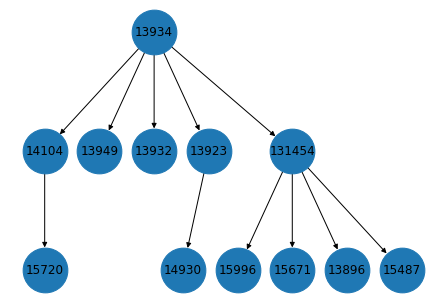

In [12]:
pos = graphviz_layout(DG, prog="dot")
nx.draw(DG, pos, with_labels=True, node_size=2000)
plt.savefig("tree")

In [13]:
def equal_structure(G, s1, s2):
    
    if len(s1) != len(s2):
        return False
    
    n = len(s1)
    
    
    ans = True
    for i in range(n):
        for j in range(n):
            if i != j:
                if ((s1[j] in get_ideal(G, [0] * N, s1[i])) and not (s2[j] in get_ideal(G, [0] * N, s2[i]))):
#                     print(f"{_id[s1[j]]} in {_id[s1[i]]}   but   {_id[s2[j]]} not in {_id[s2[i]]}")
                    ans = False
                if (not (s1[j] in get_ideal(G, [0] * N, s1[i])) and (s2[j] in get_ideal(G, [0] * N, s2[i]))):
#                     print(f"{_id[s1[j]]} not in {_id[s1[i]]}   but   {_id[s2[j]]} in {_id[s2[i]]}")
                    ans = False
    
    return ans

In [14]:
def equal_structure_robust(G, s1, s2):
    
    if len(s1) != len(s2):
        return False
    
    n = len(s1)
    
    
    ans = True
    for i in range(n):
        for j in range(n):
            if i != j:
                if ((s1[j] in get_ideal_robust(G, [0] * N, 744, s1[i])) and not (s2[j] in get_ideal_robust(G, [0] * N, 744, s2[i]))):
#                     print(f"{_id[s1[j]]} in {_id[s1[i]]}   but   {_id[s2[j]]} not in {_id[s2[i]]}")
                    ans = False
                if (not (s1[j] in get_ideal_robust(G, [0] * N, 744, s1[i])) and (s2[j] in get_ideal_robust(G, [0] * N, 744, s2[i]))):
#                     print(f"{_id[s1[j]]} not in {_id[s1[i]]}   but   {_id[s2[j]]} in {_id[s2[i]]}")
                    ans = False
    
    return ans

In [16]:
samp1 = [2149, 2319]; samp2 = [3929, 2150, 2140, 3141, 274, 4201, 3876, 2113, 3692]

alts = []
for i in range(N):
    if i not in sample:
        if equal_structure(G, sample, samp1 + [i] + samp2) and equal_structure_robust(G, sample, samp1 + [i] + samp2):
            print(i, _id[i])
            alts.append(i)
            
print(alts)

0 16384
1 16385
2 16386
3 16387
4 16388
5 16389
6 16390
7 16391
8 16392
9 16393
10 16394
11 16395
12 16396
13 16397
22 16406
23 16407
26 16410
27 131097
29 16411
30 16413
31 16412
32 16416
33 16417
35 16419
36 16420
37 16414
38 16422
39 16423
40 16424
41 16425
42 16426
43 16427
95 16479
96 16480
97 16481
98 16482
99 16483
100 16484
101 16485
102 16486
103 16487
105 16489
106 16490
107 16491
124 16508
125 16509
126 16510
127 16511
128 16512
129 16513
130 16514
131 16515
132 16516
133 16517
134 16518
135 16519
136 16520
137 16521
138 16522
139 16523
140 16524
141 16525
142 16526
143 16527
144 16528
145 16529
146 16530
147 16531
148 16532
149 16533
150 16534
151 16535
152 16536
153 16537
154 16538
155 16539
156 16540
157 16541
158 16542
159 16543
160 16544
161 16545
163 16547
164 16548
228 16617
229 16618
230 16619
231 16620
234 16623
235 16624
236 16625
238 16632
245 15893
301 128740
315 128750
317 128753
326 16415
337 16421
361 131852
362 131853
363 131854
364 131855
365 131856
366 1318

In [21]:
Alts = {
    13934: [13209, 13208, 13207],
    14104: [13207, 13208, 13209],
    13949: [13951, 13952, 13933],
    15720: [15452, 141747, 15451],
    13932: [13936, 1003333, 1003204],
    13923: [1003182, 117840, 13926],
    14930: [15332, 14561, 14930],
    16634: [13613, 13612, 13611],
    15996: [13853, 13854, 13856],
    15671: [15095, 15097, 15093],
    15098: [13853, 13854, 13856],
    14791: [13494, 13496, 13493],
    15487: [15488, 15489, 14324]
}

In [22]:
sample = [id_[u] for u in Alts.keys()]

In [23]:
for k in Alts.keys():
    print(f"Alternatives for {k}: ", end=" ")
    for v in Alts[k]:
        sample_ = sample.copy()
        for i in range(len(sample_)):
            if sample_[i] == id_[k]:
                sample_[i] = id_[v]
        print(equal_structure(G, sample, sample_), end=" ")
    print()

Alternatives for 13934:  False False False 
Alternatives for 14104:  True True True 
Alternatives for 13949:  False False False 
Alternatives for 15720:  True True True 
Alternatives for 13932:  False False False 
Alternatives for 13923:  False False False 
Alternatives for 14930:  True True True 
Alternatives for 16634:  True True True 
Alternatives for 15996:  False False False 
Alternatives for 15671:  False True True 
Alternatives for 15098:  False False False 
Alternatives for 14791:  True True True 
Alternatives for 15487:  True True True 


In [24]:
for k in Alts.keys():
    print(f"Alternatives for {k}: ", end=" ")
    for v in Alts[k]:
        sample_ = sample.copy()
        for i in range(len(sample_)):
            if sample_[i] == id_[k]:
                sample_[i] = id_[v]
        print(equal_structure_robust(G, sample, sample_), end=" ")
    print()

Alternatives for 13934:  False False False 
Alternatives for 14104:  True True True 
Alternatives for 13949:  False False False 
Alternatives for 15720:  True True True 
Alternatives for 13932:  False False False 
Alternatives for 13923:  False False False 
Alternatives for 14930:  True True True 
Alternatives for 16634:  True True True 
Alternatives for 15996:  False False False 
Alternatives for 15671:  False True True 
Alternatives for 15098:  False False False 
Alternatives for 14791:  True True True 
Alternatives for 15487:  True True True 


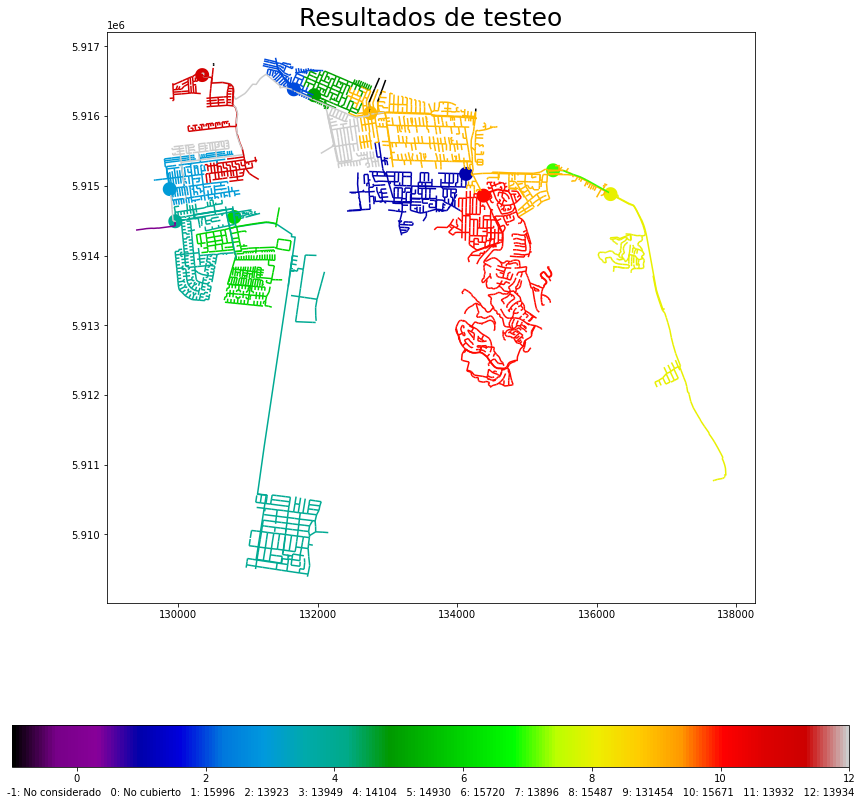

In [25]:
plot_sample_no_intersections(G, [0] * N, sample[::-1] , geometry, _id, "map_orig")

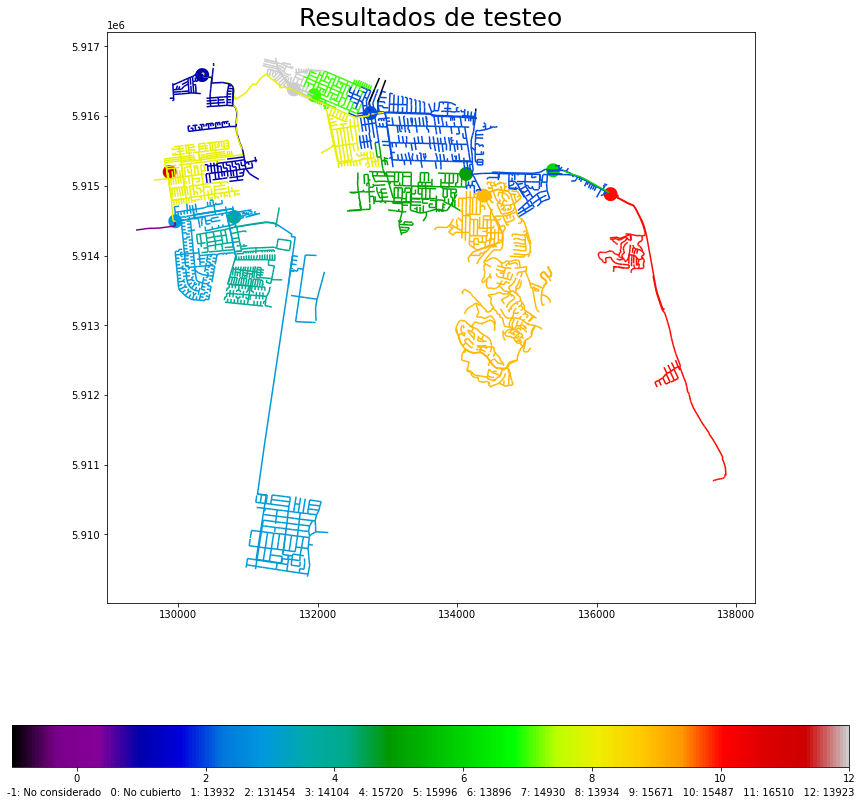

In [37]:
plot_sample_no_intersections(G, [0] * N, (samp1 + [126] + samp2)[::-1] , geometry, _id, "map_orig")

In [22]:
dists = []

U = G.to_undirected()

for a in alts:
    dists.append((nx.algorithms.shortest_paths.generic.shortest_path_length(U, 2164, a), a))

In [23]:
dists.sort()

print(dists[:10])

[(1, 2163), (1, 2165), (2, 144), (2, 1809), (3, 143), (3, 146), (3, 149), (3, 1637), (3, 1808), (4, 126)]


In [38]:
alts = [2163, 2165, 144]

alts_ = [149, 143]

alts__ = [1809, 146, 1637, 1808, 126]

In [50]:
print(_id[2150])

13932


In [39]:
print([_id[a] for a in alts])
print([_id[a] for a in alts_])
print([_id[a] for a in alts__])

[13948, 13950, 16528]
[16533, 16527]
[13586, 16530, 13414, 13585, 16510]
